In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from WindPy import w
import gensim
import json
from sklearn.tree import DecisionTreeRegressor
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.svm import SVR
from sklearn.svm import LinearSVC
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectFromModel
%matplotlib inline

In [103]:
sns.set_style("whitegrid")
sns.set_context("talk")

In [104]:
w.start()

.ErrorCode=0
.Data=[Already conntected!]

In [105]:
def wind2df(raw_data):
    dic = {}
    for data, field in zip(raw_data.Data, raw_data.Fields):
        dic[str(field.lower())] = data
    return pd.DataFrame(dic, index=raw_data.Times)

In [106]:
ASSET = "881001.WI"
START_DATE = "2012-01-01"
TRAIN_DATE = "2000-01-01"
TEST_DATE = "2017-01-01"
TODAY = datetime.datetime.today().strftime("%Y-%m-%d")
SHORT_TERM_DAYS = 63
LONG_TERM_DAYS = 490
WIND_CODE = "881001.WI"
BOND_CODE = "065.CS"
VOL_CODE = "000188.SH"
JPYCNY_CODE = "JPYCNY.EX"
KEY_WORD = u"股票"
THRESHOLD = 0.3
DATA_DIR = "C:/Users/jgtzsx01/Documents/workspace/data/wallstreetcn_words"
WEEK_WORD_COUNT_FILE = "%s/wallstreetcn_weekly_word_count.json"%(DATA_DIR)
TOTAL_WORD_COUNT_FILE = "%s/wallstreetcn_weekly_total_word_count.json"%(DATA_DIR)
WALLSTCN_MODEL = "C:/Users/jgtzsx01/Documents/workspace/model/wallstreet_model"

# 1. 获取原始数据

In [107]:
raw_data = w.wsd(ASSET, 'close', beginTime=START_DATE, endTime=TODAY)

In [108]:
raw_df = wind2df(raw_data)

In [109]:
raw_df.index.name = "Date"

# 2. 获取日收益率

In [110]:
raw_df['return'] = raw_df['close'].pct_change()

In [111]:
raw_df.dropna(inplace=True)

# 3. 获取短周期年化波动率

In [112]:
volatility = raw_df['return'].rolling(window=SHORT_TERM_DAYS).std() * np.sqrt(243)

In [113]:
volatility.name = "volatility"

In [114]:
vol_df = pd.DataFrame(volatility)

# 4. 获取短周期波动率

In [115]:
features = []

In [116]:
for k in range(7, SHORT_TERM_DAYS+1):
    feature_name = "%d-day short-term vol"%(k)
    features.append(feature_name)
    vol_df[feature_name] = raw_df['return'].rolling(window=k).std() * np.sqrt(243)

# 5. 获取长周期波动率

In [117]:
for k in range(243, LONG_TERM_DAYS+1):
    feature_name = "%d-day short-term vol"%(k)
    features.append(feature_name)
    vol_df[feature_name] = raw_df['return'].rolling(window=k).std() * np.sqrt(243)

# 6. 获取万德全A PE

In [118]:
raw_data = w.wsd(WIND_CODE, "pe_ttm", START_DATE, TODAY)

In [119]:
pe_df = wind2df(raw_data)

In [120]:
features.append('pe')
vol_df['pe'] = pe_df['pe_ttm']

# 7. 获取中债指数收益率倒数

In [121]:
raw_data = w.wsd(BOND_CODE, "ytm_b", START_DATE, TODAY, "returnType=1")

In [122]:
ytm_df = wind2df(raw_data)

In [123]:
features.append('ytm')
vol_df['ytm'] = 1 / ytm_df['ytm_b']

# 8. 获取中国波指（该指标时间太短）

In [124]:
raw_data = w.wsd(VOL_CODE, "close", beginTime=START_DATE, endTime=TODAY)

In [125]:
v_df = wind2df(raw_data)

In [126]:
features.append('vix')
vol_df['vix'] = v_df['close']

# 9. 获取日元兑人民币短周期波动率

In [127]:
raw_data = w.wsd(JPYCNY_CODE, "close", beginTime=START_DATE, endTime=TODAY)

In [128]:
jpy_df = wind2df(raw_data)

In [129]:
features.append('jpycny')
vol_df['jpycny'] = jpy_df['close']

# 10. 获取新闻关键词词频

In [130]:
word_df = pd.read_csv(u"C:/Users/jgtzsx01/Documents/workspace/data/wallstreetcn_words/股票.csv")

In [131]:
word_df['date'] = pd.to_datetime(word_df['date'], format="%Y-%m-%d")

In [132]:
word_df.set_index('date', inplace=True)

In [133]:
word_df.sort_index(inplace=True)

In [183]:
word_df['value'][word_df.index[0]]

48

In [135]:
vol_df['word'] = 0
for ind in vol_df.index:
    word_ind = ind.strftime("%Y-%m-%d")
    word_ind = pd.to_datetime(word_ind, format="%Y-%m-%d")
    if word_ind in word_df.index:
        vol_df.ix[ind, 'word'] = word_df.ix[word_ind, 'value']

In [136]:
features.append('word')
vol_df['word'] = vol_df['word'].rolling(window=7).sum()

# 机器学习模型预测

In [137]:
# feature = ['short-term vol', 'long-term vol', 'pe', 'ytm', 'jpycny', 'vix']

In [138]:
vol_df[features] = vol_df[features].shift(SHORT_TERM_DAYS)

In [139]:
vol_df = vol_df.dropna()

In [140]:
vol_df.head()

,volatility,7-day short-term vol,8-day short-term vol,9-day short-term vol,10-day short-term vol,11-day short-term vol,12-day short-term vol,13-day short-term vol,14-day short-term vol,15-day short-term vol,...,486-day short-term vol,487-day short-term vol,488-day short-term vol,489-day short-term vol,490-day short-term vol,pe,ytm,vix,jpycny,word
Date,,,,,,,,,,,,,,,,,,,,,
2015-05-18 00:00:00.005,0.239613,0.217904,0.203234,0.191394,0.181341,0.199964,0.190666,0.192859,0.249127,0.258835,...,0.205466,0.205326,0.205125,0.205078,0.204878,17.1658,0.235888,28.6316,5.1838,85.0
2015-05-19 00:00:00.005,0.243706,0.242067,0.233778,0.221806,0.211718,0.200961,0.211080,0.202171,0.201476,0.248693,...,0.205744,0.205542,0.205401,0.205201,0.205152,17.4344,0.235882,28.7454,5.1929,70.0
2015-05-20 00:00:00.005,0.244064,0.229605,0.233091,0.229084,0.220105,0.212251,0.202374,0.209571,0.201574,0.200079,...,0.205848,0.205647,0.205445,0.205305,0.205105,17.5997,0.237242,26.4399,5.1582,58.0
2015-05-21 00:00:00.005,0.247939,0.188377,0.213232,0.219709,0.218501,0.211820,0.205797,0.197054,0.203379,0.196300,...,0.205794,0.205664,0.205463,0.205262,0.205122,17.7011,0.238152,25.7972,5.1238,58.0
2015-05-22 00:00:00.005,0.248873,0.194400,0.187705,0.205871,0.215130,0.216361,0.211606,0.207120,0.199129,0.203417,...,0.205938,0.205754,0.205623,0.205423,0.205222,17.9132,0.239366,23.4082,5.1729,58.0


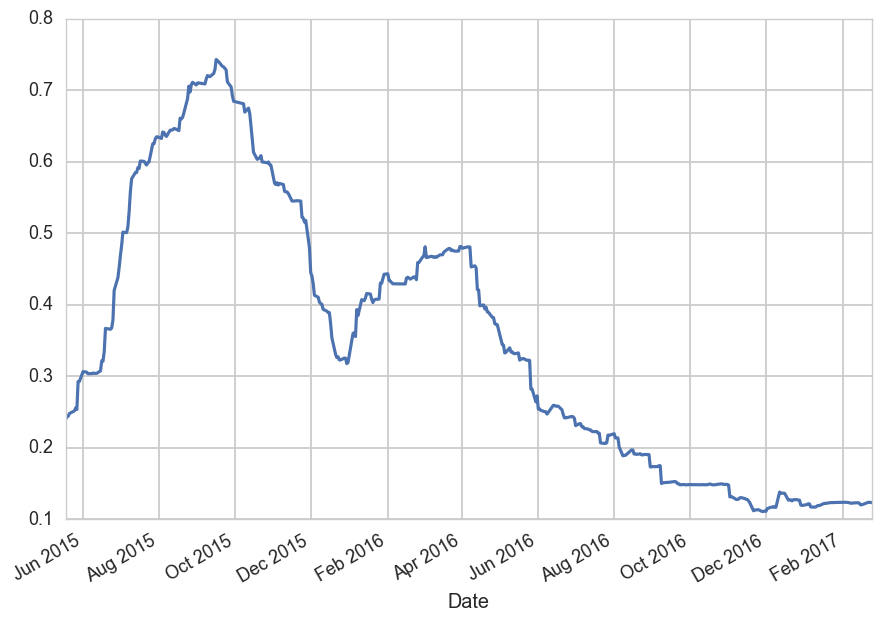

In [141]:
vol_df['volatility'].plot()

In [142]:
train_df = vol_df[vol_df.index < TEST_DATE]
test_df = vol_df[vol_df.index >= TEST_DATE]

# Feature Selection

In [143]:
trainX, trainY = train_df[features], train_df['volatility']
testX, testY = test_df[features], test_df['volatility']

In [170]:
clf = linear_model.LassoCV()
# clf = linear_model.Lasso(alpha=0.0005)

In [171]:
clf.fit(trainX, trainY)

LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [172]:
clf.coef_

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.  

In [173]:
sfm = SelectFromModel(clf, prefit=True)

In [174]:
feaX = sfm.transform(trainX)

In [175]:
feaX.shape

(400, 4)

In [176]:
def metrics(model, sfm):
    model.fit(feaX, trainY)
    train_pred = model.predict(feaX)
    test_pred = model.predict(sfm.transform(testX))
    plt.plot(vol_df.index, vol_df['volatility'].values)
    plt.plot(train_df.index, train_pred)
    plt.plot(test_df.index, test_pred)
    print("training correlation: %.2f"%(np.corrcoef(trainY, train_pred)[0][1]))
    print("testing correlation: %.2f"%(np.corrcoef(testY, test_pred)[0][1]))
    print("training R2: %2.f"%(r2_score(trainY, train_pred)))
    print("testing R2: %.2f"%(r2_score(testY, test_pred)))
    print("training RMSE: %.2f"%(mean_squared_error(trainY, train_pred)))
    print("testing RMSE: %.2f"%(mean_squared_error(testY, test_pred)))

### Linear Regression

In [177]:
lr = linear_model.LinearRegression()

training correlation: 0.98
testing correlation: -0.02
training R2:  1
testing R2: -276.98
training RMSE: 0.00
testing RMSE: 0.00


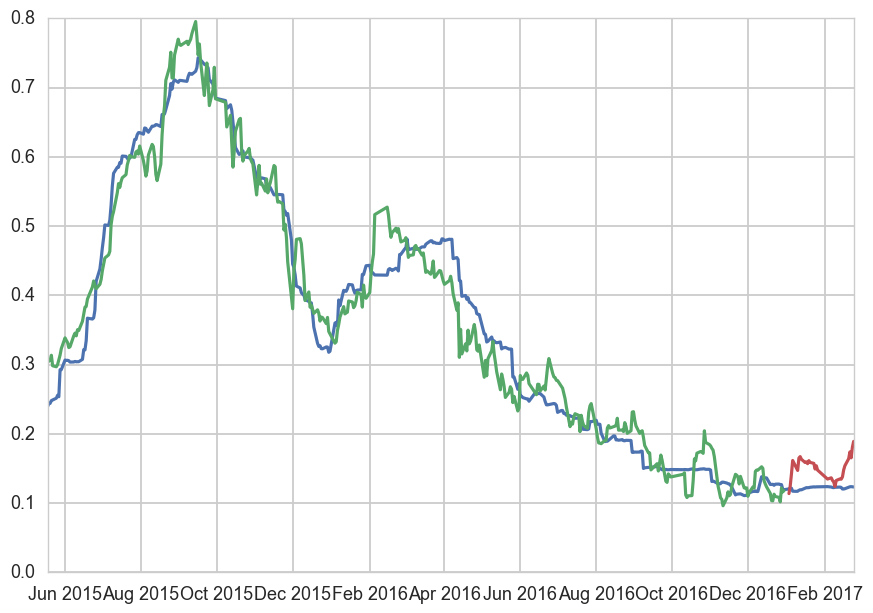

In [178]:
metrics(lr, sfm)

### SVR

In [179]:
svr = SVR(kernel='linear')

training correlation: 0.98
testing correlation: 0.17
training R2:  1
testing R2: -1760.77
training RMSE: 0.00
testing RMSE: 0.01


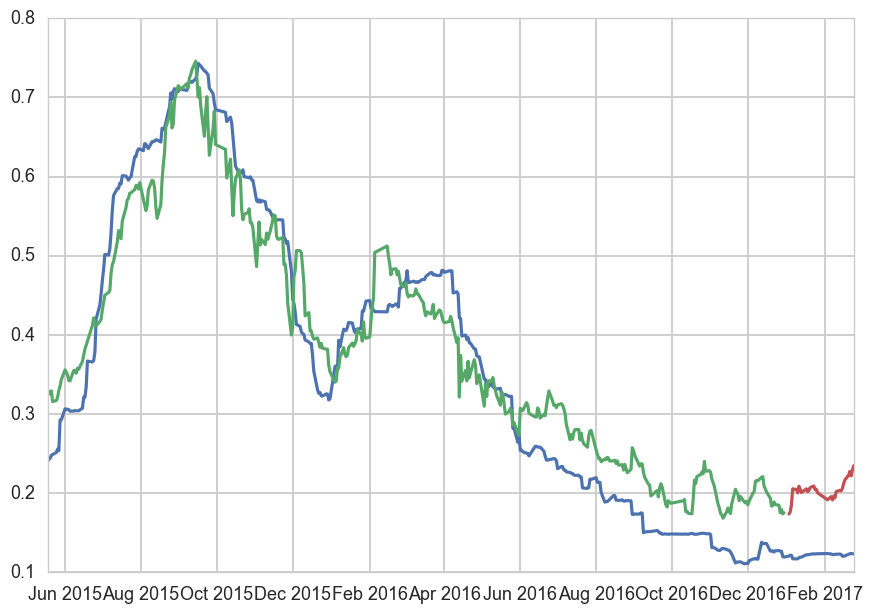

In [180]:
metrics(svr, sfm)

### Kernel Ridge

In [181]:
krr = KernelRidge(kernel='linear')

training correlation: 0.96
testing correlation: 0.26
training R2:  1
testing R2: -754.13
training RMSE: 0.00
testing RMSE: 0.00


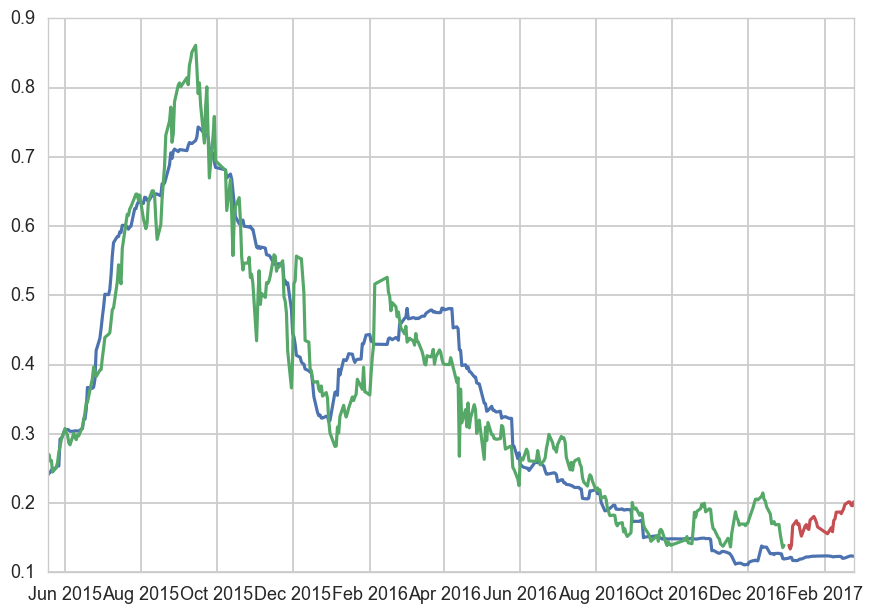

In [182]:
metrics(krr, sfm)